In [1]:
print ("Python is easy!")

Python is easy!


In [2]:
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import statistics
import cv2
import os

In [3]:
def showimage(image, name='image'):
    cv2.namedWindow(name)
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return

In [4]:
def PreProcessImage(image):
    ## bilateral, followed by sharpening, followed by medianfilter
    for i in range(100):
        image = cv2.bilateralFilter(image,2,10,10)
    cv2.imwrite('bilateral-1.jpg', image)

    sharpen = np.array(([0, -1, 0],
                        [-1, 5, -1],
                        [0, -1, 0]), dtype="int")
    image = cv2.filter2D(image, -1, sharpen)
    showimage(image,'sharpened')
    cv2.imwrite('sharpen-2.jpg', image)

    image = cv2.medianBlur(image,3)
    showimage(image,'medianblurred')
    cv2.imwrite('median-3.jpg', image)
    return image


def DoGammaCorrections(image, gamma=1.0):
    img2 = image.copy()
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 
                      for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(img2, table)

def ThresholdWithOTSU(image):
    thirdH = int(image.shape[0]/3)
    thirdW = int(image.shape[1]/3)
    roi = image[thirdH:2*thirdH, thirdW:2*thirdW] 
    
    histr = cv2.calcHist([image],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()

    histr = cv2.calcHist([roi],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()
       
    v = np.median(roi)
    print('median is', v)
    
    img2 = image.copy()
    ot, roit = cv2.threshold(roi, 0, 255, cv2.THRESH_OTSU)    
    _, ti = cv2.threshold(img2, ot, 255, cv2.THRESH_BINARY_INV)
    
    return ot, ti 

def GetCannyThresholds(image):
    #v = np.median(roi)
    #print('median is', v)
    
    ot,_ = ThresholdWithOTSU(image)

    v = ot
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return lower, upper

In [94]:
cwd = os.getcwd()
print('cwd', cwd)
os.chdir('..\Canonical3')
print('now', os.getcwd())

cwd C:\Users\darshat\desktop\ImageWork\Python
now C:\Users\darshat\desktop\ImageWork\Canonical3


Image size and shape  9240000 (1232, 2500, 3)


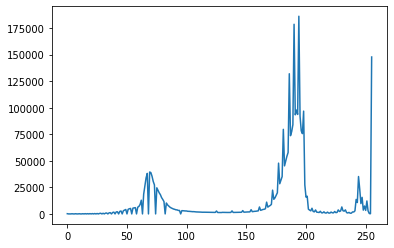

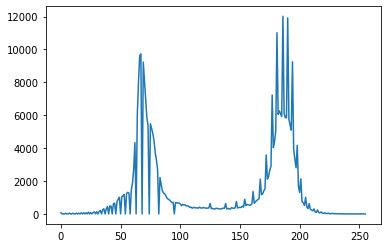

median is 166.0
otsu threshold 128.0


In [95]:
img = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
print("Image size and shape ", img.size, img.shape)
## Shape=(y,x)

## Update these flags. Currently used to determine some pre/post processing steps
isGrantha=0
isDevnagri=1

## Step 0. Trim 20 pixels off the boundaries. Boundaries can include black shadows that interfere with
## margin and edge calculations. Is there a better way to remove the edges? TODO
img[:20] = 255
img[-20:] = 255
img[:,:20] = 255
img[:,-20:] = 255
showimage(img, 'trimmed')
cv2.imwrite('trimmed-0.jpg', img)

## Steps 1-3 are preprocessing - bilateral, sharpen, medianblur
img = PreProcessImage(img)
grayimage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


## Step 4. Generate variant with high intensities to wash out more of light background.
## Ideally this should be tied to 'darkness' of the image. 
img = DoGammaCorrections(grayimage, 1.4)
showimage(img, 'gamma corrected')
cv2.imwrite('gamma-4.jpg', img)

## Step 5. This differs based on image type?? 
#5a Convert to binary with Otsu
otsu, img = ThresholdWithOTSU(img)
print('otsu threshold', otsu)
showimage(img, 'otsu thresholded')
cv2.imwrite('otsu-bw-5.jpg', img)

#5b We can use Canny instead to find edges. Condition this on stroke width or something else? 
## Canny performs badly on wide stroke width and finds edges inside the stroke leading to messy contours
## OTOH Otsu thresholding is dicey with narrow stroke width and leads to pixels getting removed and discontinuity
"""l, u = GetCannyThresholds(image)
print('canny lower, upper', lower, upper)
image = cv2.Canny(image,l,u,L2gradient=True)
showimage(image, 'canny output')
cv2.imwrite('cannyoutput-5.jpg', image)"""

if (isGrantha==1):
    ## Step 6. Close image with elliptic element for Granthi
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, se1, iterations=1)

    showimage(img, 'closed image')
    cv2.imwrite('morphology-6.jpg', img)

In [96]:
def showrowhist(img):
    ## rowwise sum, should return a column of height #rows, with each entry being sum of pixel
    ## intensities
    sum_x = cv2.reduce(img, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    return sum_x

def getlinewidth(lp):
    ## multiple ways to calculate avg line width. Can take median of h values. Or if variance is high,
    ## can take diff of line positions in that vicinity which will be more accurate?
    sum = 0
    for (i, l) in enumerate(lp):
        if (i>0):
            sum += lp[i]-lp[i-1]
    return int(sum/(len(lp)-1))

def findlines2(y):
    linepositions = []
    max_y = np.max(y)
    half = int(max_y/2)
    lower_range = int(max_y/3)
    upper_range = 2*int(max_y/3)
    mean = np.mean(y)
    
    currentmax = 0
    currentmaxindex = -1
    currentmin = lower_range
    currentminindex = -1
    
    textstartindex = -1
    for i in range(0, len(y)):
        if (y[i]>=lower_range):
            textstartindex = i
            print("text starts at row ", textstartindex)
            break;
    
    withinline=False
    print('lower_range', lower_range)
    
    for i in range(0, len(y)):
        if (y[i]>=lower_range):
            if (withinline==False):
                withinline=True
                print('found trough at', currentminindex, i)
                linepositions.append(currentminindex)
                currentmin=max_y
        else:
            if (withinline==True):
                withinline=False
                #print('found peak at ', currentmaxindex, i)
                currentmax=0
                currentmaxindex=i
            
        if (withinline):
            ## start tracking peak
            if (y[i]>currentmax):
                currentmax=y[i]
                currentmaxindex=i
        else:
            if (y[i]<currentmin):
                currentmin = y[i]
                currentminindex=i
    
    #after last peak i.e. intensityl>ower_range, we may not cross the lower_range again. Last peak still needed
    if (withinline==False):
        if (len(linepositions)>=2):
            lastRecordedLine = linepositions[-1]
            lastLine = lastRecordedLine + getlinewidth(linepositions)
            linepositions.append(lastLine)
        else:
            lastLine = currentminindex
            linepositions.append(lastLine)
        print('new adding estimate of last line', lastLine)
    
    return linepositions
            

def findlines(y):
    linepositions = []
    max_y = np.max(y)
    lower_range = int(max_y/3)
    upper_range = 2*int(max_y/3)
    mean = np.mean(y)
    
    currentmin = mean
    currentminindex = -1
    recordingLinePending = False
    
    textstartindex = -1
    for i in range(0, len(y)):
        if (y[i]>upper_range):
            textstartindex = i
            print("text starts at row ", textstartindex)
            break;
            
    for i in range(textstartindex+1, len(y)):
        if (y[i] > upper_range):
            recordingLinePending = True
        elif (y[i] >= lower_range):
            ## this is meant to catch the upward trend after crossing a troughs
            if (currentminindex != -1 and recordingLinePending == True):
                ## we are in block of text, intensity crossing lower band, record current minima
                linepositions.append(currentminindex)
                print("adding minima ", currentminindex)
                currentmin = lower_range
                currentminindex = -1
                recordingLinePending = False
        else:
            ## if intensity is below average start tracking
            if (y[i]<currentmin):
                currentmin = y[i]
                currentminindex = i
       
    #after last peak i.e. intensity>upper_range, we may not cross the lower_range again. Last peak still needed
    if (recordingLinePending):
        if (len(linepositions)>=2):
            lastRecordedLine = linepositions[-1]
            lastLine = lastRecordedLine + getlinewidth(linepositions)
            linepositions.append(lastLine)
        else:
            lastLine = currentminindex
            linepositions.append(lastLine)
        print('adding estimate of last line', lastLine)
    return linepositions

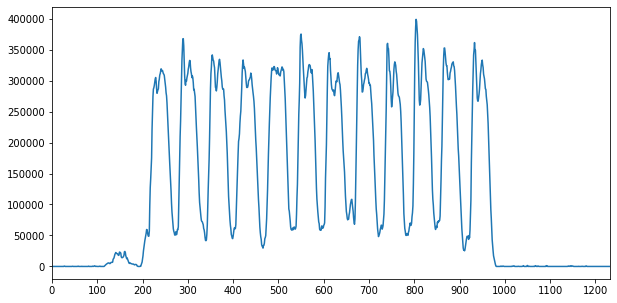

text starts at row  223
adding minima  272
adding minima  340
adding minima  399
adding minima  466
adding minima  530
adding minima  594
adding minima  668
adding minima  721
adding minima  782
adding minima  847
adding minima  911
adding estimate of last line 974
12
text starts at row  218
lower_range 132940
found trough at 0 218
found trough at 272 281
found trough at 340 346
found trough at 399 409
found trough at 466 477
found trough at 530 543
found trough at 594 604
found trough at 668 671
found trough at 721 735
found trough at 782 799
found trough at 847 859
found trough at 911 926
new adding estimate of last line 993
13
linewidth estimate 82


In [97]:
peakdata = showrowhist(img)
plt.figure(figsize=(10,5))
plt.plot(peakdata)
plt.xticks(range(0, img.shape[0], 100))
plt.xlim([0, img.shape[0]])
plt.show()

linepositions = findlines(peakdata)
print(len(linepositions))
linepositions= findlines2(peakdata)
print(len(linepositions))
np.savetxt("intensityprojections.csv", peakdata, delimiter=",")
np.savetxt("linepositions.csv", linepositions, delimiter=",")
linewidth = getlinewidth(linepositions) 
print('linewidth estimate', linewidth)

In [98]:
def FindMargins(img):
    ## sum intensities along the columns
    sum_cols = cv2.reduce(img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).T
    plt.plot(sum_cols)
    plt.xlim([0, img.shape[1]])
    plt.show()
    
    max_i = np.max(sum_cols)
    lower_range = int(max_i/3)
    upper_range = 2*int(max_i/3)
    mean = np.mean(sum_cols)
    
    leftIndex = 0
    rightIndex = img.shape[1]
    
    for i in range(0, len(sum_cols)):
        if (sum_cols[i]>lower_range):
            leftIndex = i-20
            break;
            
    ## invert the array and find right margin
    for i in range(len(sum_cols)-1, leftIndex, -1):
        if (sum_cols[i]>lower_range):
            rightIndex = i+20
            break
    return leftIndex, rightIndex    

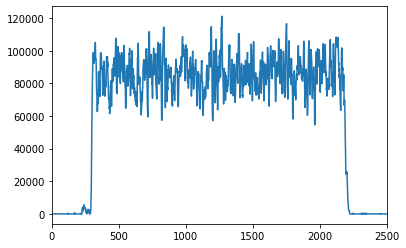

left and right margins 277 2211


In [99]:
lm, rm = FindMargins(img)
print('left and right margins', lm, rm)


In [100]:
def GetContours(image):
    img1 = image.copy()
    showimage(img1, 'contour input')
    cv2.imwrite('inputtocontouring.jpg', img1)
    contours, _ = cv2.findContours(img1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)    
    return contours

def GetContoursWithErosionDilation(image):
    img2 = image.copy()
    kernel = np.ones((3,3), np.uint8) 
    img_erosion = cv2.erode(img2, kernel, iterations=1) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    showimage(img_dilation)
    contours, _ = cv2.findContours(img_dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    return contours

def EmitLinesAndRects(lines, rects, oi, bi, rectcolor, linecolor):
    for (i, r) in enumerate(rects):
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)
        cv2.rectangle(bi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)

    for _, i in enumerate(lines):
        cv2.line(oi, (0,i), (img.shape[1],i), linecolor, 1)
        cv2.line(bi, (0,i), (img.shape[1],i), linecolor, 1)
    

def EmitLinesAndConvexHulls(lines, hulls, oi, bi, hullcolor, linecolor):
    cv2.drawContours(oi, hulls, -1, hullcolor, 1)
    cv2.drawContours(bi, hulls, -1, hullcolor, 1)
    
    for _, i in enumerate(lines):
        cv2.line(oi, (0,i), (img.shape[1],i), linecolor, 1)
        cv2.line(bi, (0,i), (img.shape[1],i), linecolor, 1)
    

In [101]:
## Run contouring only on section where lines are detected. This is to avoid:
## a) picking up boundary of image as one giant contour which otherwises forces heirarchical contouring
## b) less postprocessing to pickup contours outside roi

yLower = max(0,int(linepositions[0]-1.3*linewidth))
yUpper = min(img.shape[0],int(linepositions[-1]+0.3*linewidth))
print('mask boundary rows, lower & upper', yLower, yUpper)

maskedImg = img.copy()
## Set regions outside roi to black. Note image is white text on black background
maskedImg[0:yLower, :] = 0
maskedImg[yUpper:img.shape[0], :] = 0
    
contours = GetContours(maskedImg)
#contours = GetContoursWithErosionDilation(maskedImg)
print('total contours', len(contours))

boundingrects = []
convexhulls = []

for (i, c) in enumerate(contours):
    # compute bounding box of contour
    r = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    boundingrects.append(r)
    convexhulls.append(hull) 

mask boundary rows, lower & upper 0 1017
total contours 728


In [102]:
def GetImageForConvexHull(hull):
    # create a blank image of size w,h. br is (x,y,w,h)
    ### absolute coordinates cause an issue with hull rendering.
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask,[hull],-1,(255,255,255),-1)
    mask = cv2.bitwise_and(img, img, mask=mask)
    return mask
    
def BreakMergedCharsViaHull(mask, rect, output):
    # split image approx around mid point where intensity projection is weakest
    hist = cv2.reduce(mask, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    #plt.plot(hist)
    #plt.xlim([0, mask.shape[0]])
    #plt.show()
    
    max_y = np.max(hist)
    (x,y,w,h) = rect
    # some sensible default
    currentmin = max_y
    currentminindex = y + int(h/2)
    
    # first y rows should be empty, hull starts around y'th row
    # look for minima in the 35-65% band in the middle
    #print('checking histogram range y, y+h', y, y+h)
    for i in range(y, y+h):
        if (i>0.35*h+y and i<0.65*h+y):
            ## if intensity is below average start tracking
            if (hist[i]<currentmin):
                currentmin = hist[i]
                currentminindex = i
                # print('updating minindex to', i)
    
    # print('x,y,currentminindex,h,w', x,y,currentminindex,h,w)
    
    # now redo contouring in each subpart and report the bounding rectangles.
    mask1 = mask.copy()
    mask2 = mask.copy()
    
    mask1[currentminindex:y+h, x:x+w]=0
    mask2[0:currentminindex, x:x+w]=0
    # showimage(mask1)
    # showimage(mask2)
    
    c1,_ = cv2.findContours(mask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    c2,_ = cv2.findContours(mask2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    for (_, c) in enumerate(c1):
        # compute bounding box of contour
        # print('upper contour', c)
        r = cv2.boundingRect(c)
        output.append(r)
        # print('upper broken rect', r)
    for (_, c) in enumerate(c2):
        # compute bounding box of contour
        # print('lower contour', c)
        r = cv2.boundingRect(c)
        output.append(r)
        # print('lower broken rect', r)

In [103]:
def boundcheck(rect, line, prevline, linewidth):
    ## rectangle bounds are (x,y) (x+w, y+h). Rect is x,y,w,h. If y+h is less than line & greater than line-1
    if (prevline is None):
        prevline = line-linewidth
    
    if (rect[1]<prevline-0.3*linewidth):
        #print('Skipping rect because it starts before previous line', rect, line)
        return False
    if (rect[1]>line):
        #print('Skipping rect because it starts after line', rect, line)
        return False
    
    if (rect[1]+rect[3] <= line):
        #print('Adding rect because it is between line and prevline:', rect, line, prevline)
        return True
    elif (rect[1]+rect[3] > line and (rect[1]+rect[3] < line+0.3*linewidth)):
        #print('Adding rect because it starts above line:', rect, line)
        return True
    
    return False

def ShowBoundingRects(cbr, oi):
    for (j, r) in enumerate(cbr):
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (255,0,255), 1)
    showimage(oi)
    
def GetImageForRect(r):
    # get region from image to break. [y:y+h,x:x+w]
    roi = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
    return roi

def BreakMergedCharsViaErode(x,y, roi, linewidth, output):
    kernel = np.ones((3,3), np.uint8)
    eroded_rect = cv2.erode(roi, kernel, iterations=1) 
    #showimage(eroded_rect)
    #print('eroded shape', eroded_rect.shape)
    
    contours, _ = cv2.findContours(eroded_rect,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for (_, c) in enumerate(contours):
        rc = cv2.boundingRect(c)
        if (rc[3]/linewidth < 1.2):
            #print('broken down!')
            # ensure x,y are absolute to original image
            output.append((x+rc[0], y+rc[1], rc[2], rc[3]))
        else:
            #print('not broken with this erosion, try again')
            #TODO need to pass image roi corresponding to rc and not original so that subrectangles are correctly done
            BreakMergedCharsViaErod(x, y, eroded_rect, linewidth, output)

In [104]:
def PreProcessBoundingRects1(boundingrects, convexhulls, linewidth):
    br = boundingrects.copy()
    simpleboundingrects = []
    compoundboundingrects = []
    
    for (i, rect) in enumerate(br):
        #h is rect[3]
        if (rect[3]/linewidth < 1.2):
            simpleboundingrects.append(rect)
        else:
            compoundboundingrects.append(rect)
    
    print('# simple rects', len(simpleboundingrects))
    print('# compound rects', len(compoundboundingrects))
    
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(compoundboundingrects, oi)
    cv2.imwrite('compoundrects.jpg', oi)
    
    
    # refactor this to call either routine. Break out splitmultiline into its own function
    # process the problem rects this way
    # erode the rect contents till it splits in two (or more) vertical rects
    output = []
    for (_, r) in enumerate(compoundboundingrects):
        # Hull break method
        index = boundingrects.index(r)
        hull = convexhulls[index]
        # print('compound char rect & hull:', r, hull)
        mask = GetImageForConvexHull(hull)
        # showimage(mask)
        BreakMergedCharsViaHull(mask, r, output)
        #print('broken rects len', len(output))
        
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(output, oi)
    cv2.imwrite('compoundrectsbroken.jpg', oi) 
    
    for (_, r) in enumerate(output):
        simpleboundingrects.append(r)
    return simpleboundingrects

def contains(r1, r2):
    if (r1 != r2):
        return r1[0] <= r2[0] and r2[0]+r2[2] <= r1[0]+r1[2] and r1[1] <= r2[1] and r2[1]+r2[3] <= r1[1]+r1[3]
    return False
    
def PreProcessBoundingRects2(boundingrects):
    areas = []
    br = []
    for (_, small) in enumerate(boundingrects):
        a = small[2]*small[3]
        areas.append(a)
        if (a>4):
            # check this is not contained fully in another other rect
            contained = False
            for (_, big) in enumerate(boundingrects):
                if contains(big,small):
                    contained = True
                    break
            if (contained == False):
                br.append(small)
            #else:
            #    print('small contained in big', small, big)
        #else:
            #print('too small', small)
            
    np.savetxt("boundingrectsAreas.csv", areas, fmt="%s", delimiter=",")
    return br;

def ShouldMerge(r1, r2):
    ## need additional criteria here. e.g. overlap with a narrow vertical or horizontal char should be ok.
    a1 = r1[2]*r1[3]
    a2 = r2[2]*r2[3]
    
    xOverlap = (r1[0]<=r2[0] and r1[0]+r1[2]>=r2[0]) or (r1[0]>=r2[0] and r1[0]<=r2[0]+r2[2])
    yOverlap = (r1[1]<=r2[1] and r1[1]+r1[3]>=r2[1]) or (r1[1]>=r2[1] and r1[1]<=r2[1]+r2[3])
    y_r1_CloseAbove_r2 = r2[1]>r1[1]+r1[3] and r2[1]<r1[1]+r1[3]+int(0.3*linewidth)
    y_r1_CloseBelow_r2 = r1[1]>r2[1]+r2[3] and r1[1]<r2[1]+r2[3]+int(0.3*linewidth)
    yCloseEnough = y_r1_CloseAbove_r2 or y_r1_CloseBelow_r2
    
    #if (xOverlap and yOverlap):
    #    print('r1 overlap r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseAbove_r2):
    #    print('r1 close above r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseBelow_r2):
    #    print('r1 close below r2', r1, r2)
    
    ## merge only large left r1 with small right r2, this simplifies bookkeeping at expense of some more iterations
    ## character height vs linewidth is a heuristic. If one of the characters has height less than 0.3 of line width
    ## consider merging. If the lines are quite apart then median char height could be used instead.
    if (xOverlap and (yOverlap or yCloseEnough)):
        #if (a1/a2 >2):
        if (r1[3]<=int(0.3*linewidth) or r2[3]<=int(0.3*linewidth)):
            ## on the same line x overlap is enough to merge. On the top line add a qualifier for y overlap
            #print('a1/a2>2', r1, r2)
            return True
        else:
            ## rectangles are closer in size. Proceed carefully. Merge in vertical is safer than merge in horizontal
            ## 1) if extent of x overlap is close to r2 width, merge r2 into r1. r2 is to right of r1. This is either
            ##    vertical stack case or matras that are narrow slivers to the right. 
            ## 2) if extent of y overlap is fully above or below the center line of r1. r2 is to right of r1. This is 
            ##    some parts of r1 are fragmented and to the right
            if (r2[0]>=r1[0]):
                overlap = min(r2[0]+r2[2], r1[0]+r1[2])-max(r1[0], r2[0])
                if (overlap > int(0.8*r2[2])):
                    print('r2 significant overlap with r1', r1, r2, overlap)
                    return True
                if ((r2[1]>r1[1]+int(0.5*r1[3])) and r2[1]<r1[1]+r1[3]):
                    ## r2 is between middle and bottom of r1  |=
                    print('r2 more than midway down r1', r1, r2)
                    return True
                if ((r1[1]>r2[1]+int(0.5*r2[3])) and r1[1]<r2[1]+r2[3]):
                    ## r1 is between middle and bottom of r2 =|
                    print('r1 more than midsway down r2', r1, r2)
                    return True
        #else:
        #    print('r1 not bigger than r2 to right, no merge', r1, r2)
    return False
    
def PreProcessBR3(linerects):
    ## call the recursive routine few times. Because merging can create more overlaps instead of complicated
    ## logic just run this routine multiple times and it should result in convergence till count doesnt decrease
    dr = []
    currentLineRects = linerects.copy()
    
    for i in range(1,3):
        print('merge iteration', i)
        currentLineRects = PreProcessBoundingRects3(currentLineRects, dr)
        
    return currentLineRects

def PreProcessBoundingRects3(linerects, discardedrects=[]):
    ## find overlapped rectangles in a line and see if they can be merged
    ## There are two conditions:
    ## 1) There must be an overlap or touching of borders. Look in window of 5 rects before/after
    ## 2) The areas of rectangles must be dissimilar. Current magic ratio is 2
    
    mergeOccurred = False
    mergedlinerects = []
    
    for (i, r1) in enumerate(linerects):
            
        if (r1 in discardedrects):
            continue
        lookback=max(0,i-5)
        lookahead=min(i+5,len(linerects))
        for (j, r2) in enumerate(linerects[lookback:lookahead]):
            
                
            if (r1 == r2):
                continue
            if (r2 in discardedrects):
                continue
            
            #print('checking r1 and r2', r1, r2)
            if (ShouldMerge(r1, r2)):
                #print('merging r1 and r2', r1, r2)
                x1 = min(r1[0], r2[0])
                y1 = min(r1[1], r2[1]) 
                x2 = max(r1[0]+r1[2], r2[0]+r2[2])
                y2 = max(r1[1]+r1[3], r2[1]+r2[3])
                w = x2-x1
                h = y2-y1
                r1 = (x1,y1,w,h)
                #print('merged **r1** and r2', r1, r2)
                mergeOccurred = True
                discardedrects.append(r2)
            #else:
             #   print('r1 r2 dont satisfy criteria for merge', r1, r2)
            
        # at end of inner loop, r1 didnt overlap, or it did and has new values. Either way add to output
        mergedlinerects.append(r1)
    
    ## debug
    #print('new series:', mergedlinerects)
    #print('discarded series', discardedrects)
    
    if (mergeOccurred):
        #print('atleast one merge happened, processing again')
        mergedlinerects = PreProcessBoundingRects3(mergedlinerects, discardedrects)
        
    #print('merged rects', mergedlinerects)
    #print('discarded rects', discardedrects)
    return mergedlinerects


def PostProcessBoundingRects4(linerects, linewidth):
    ## after all processing remove rects that dont have good content, or are outside the left/right margins
    ## for now remove rects with very skewed aspect ratio
    updatedlinerects=[]
    
    for (i, rc) in enumerate(linerects):
        outputline = []
        for (j, r) in enumerate(rc):
            if (r[0]+r[2]<lm or r[0]>rm):
                print('removing rectange outside margins', r)
                continue
                
            if (r[3]>int(linewidth/5) or r[2]<4*r[3]):
                if (r[2]>5 and r[3]>5):
                    outputline.append(r)
                else:
                    print('removing very small rect', r)
            else:
                print('removing junk content rectange', r)
                
        updatedlinerects.append(outputline)
    return updatedlinerects
                

                    

def ArrangeLineByLine(boundingrects, linepositions):
    splitchars = []
    br = boundingrects.copy()
    
    for (i, l) in enumerate(linepositions):
        charsinline = []
        ##split bounding rects by linepos
        if (i==0):
            for (j, rect) in enumerate(br):
                if (boundcheck(rect, linepositions[0], None, linewidth)):
                    charsinline.append(rect)
        else:
            for (j, rect) in enumerate(br):
                if (boundcheck(rect, linepositions[i], linepositions[i-1], linewidth)):
                    charsinline.append(rect)
                    
        # remove the rects that got assigned to that line
        br = [x for x in br if x not in charsinline]
        
        #print('#rects left after line', len(br), i)
        # append sorted by x position
        charsinline.sort(key = lambda x: x[0]) 
        splitchars.append(charsinline)
        print('chars by line:', i, len(charsinline))
    
        
    if (len(br)>0):
        # leftovers?
        #leftovers = []
        #for (j, rect) in enumerate(br):
        #    leftovers.append(rect)
        #splitchars.append(leftovers)
        print('chars with indeterminate line:', len(br))
    
    return splitchars, br

In [105]:
# split any rect spanning lines into smaller rects
br = PreProcessBoundingRects1(boundingrects, convexhulls, linewidth)

# remove very small rects or fully contained in another
br = PreProcessBoundingRects2(br)

oi1 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi1 = oi1.copy()
bi1[:,:,:] = 255

EmitLinesAndRects(linepositions, br, oi1, bi1, (255,0,0), (0,255,0))
showimage(oi1, 'lines and rects')
showimage(bi1, 'only lines and rects')

cv2.imwrite('withrectsandlines.jpg', oi1)
cv2.imwrite('onlyrectsandlines.jpg', bi1) 
np.savetxt("boundingrects.csv", br, fmt="%s", delimiter=",")

oi2 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi2 = oi2.copy()
bi2[:,:,:] = 255
EmitLinesAndConvexHulls(linepositions, convexhulls, oi2, bi2, (255,0,0), (0,255,0))
showimage(oi2, 'lines and hulls')
showimage(bi2, 'only lines and hulls')
cv2.imwrite('withconvexhullsandlines.jpg', oi2)
cv2.imwrite('onlyconvexhullsandlines.jpg', bi2) 

linerects, uncertainchars = ArrangeLineByLine(br, linepositions)



## merge certain rectangles after line numbering assigned
updatedlinerects = []
for _,lr in enumerate(linerects):
    mergedlr = PreProcessBR3(lr)
    updatedlinerects.append(mergedlr)

## final cleanup to trim rects with skewed aspect ratio or lying outside margins
updatedlinerects = PostProcessBoundingRects4(updatedlinerects, linewidth)
      
oi3 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi3 = oi3.copy()
bi3[:,:,:]=255

numchar = 0
for (i, rc) in enumerate(updatedlinerects):
    for (j, r) in enumerate(rc):
        cv2.rectangle(oi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        cv2.rectangle(bi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        numchar = numchar+1
                      
for (k, r) in enumerate(uncertainchars):
    cv2.rectangle(bi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (0,0,255), 1)

for _, i in enumerate(linepositions):
    cv2.line(oi3, (0,i), (img.shape[1],i), (127,0,127), 1)
    cv2.line(bi3, (0,i), (img.shape[1],i), (127,0,127), 1)

print('total chars after processing', numchar)
showimage(oi3, 'final image')
cv2.imwrite('finalimage.jpg', oi3)
showimage(bi3, 'final image with rects')
cv2.imwrite('finalimagelinesandrects.jpg', oi3)
cv2.imwrite('finalimageonlylinesandrects.jpg', bi3)
np.savetxt("boundingrects.csv", updatedlinerects, fmt="%s", delimiter=",")

# simple rects 722
# compound rects 6
chars by line: 0 0
chars by line: 1 51
chars by line: 2 44
chars by line: 3 37
chars by line: 4 40
chars by line: 5 42
chars by line: 6 41
chars by line: 7 54
chars by line: 8 39
chars by line: 9 41
chars by line: 10 42
chars by line: 11 42
chars by line: 12 42
chars with indeterminate line: 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
removing junk content rectange (419, 148, 26, 6)
removing very small rect (932, 93, 4, 3)
removing very small rect (1452, 157, 3, 2)
removing very small rect (1869, 537, 3, 2)
removing rectange outsi

In [50]:
## This prints the bounding rect coordinates. 2D array so csv print needs some more parsing.
np.savetxt("boundingrects.csv", updatedlinerects, fmt="%s", delimiter=",")

In [93]:
os.chdir(cwd)

In [ ]:
## random stuff after this

oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
# save 1st, 5,6,7th chars of line 1 in separate files
line1 = linerects[0]
(x,y,w,h) = line1[1]

char1 = oi[y:y+h,x:x+w]
cv2.imwrite('char1.jpg', char1)

(x,y,w,h) = line1[14]
char14 = oi[y:y+h,x:x+w]
cv2.imwrite('char14.jpg', char14)

(x,y,w,h) = line1[15]
char15 = oi[y:y+h,x:x+w]
cv2.imwrite('char15.jpg', char15)

(x,y,w,h) = line1[16]
char16 = oi[y:y+h,x:x+w]
cv2.imwrite('char16.jpg', char16)

In [ ]:
line1


In [ ]:
##kernel = np.ones((2,2), np.uint8)
##imgerode = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_GRAYSCALE)
##blur = cv2.GaussianBlur(imgerode, (3,3), 0)
##ret, adtimage = cv2.threshold(blur, 115, 255, cv2.THRESH_BINARY_INV)
##img_erosion = cv2.erode(adtimage, kernel, iterations=1) 
##cv2.imwrite('erodedimage.jpg', img_erosion)

##blankimgeroded = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_ANYCOLOR)
##blankimgeroded[:,:,:] = 255
##contours, _ = cv2.findContours(img_erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
##for (i, c) in enumerate(contours):
    # compute bounding box of contour
##    (x, y, w, h) = cv2.boundingRect(c)
##    cv2.rectangle(blankimgeroded, (x,y), (x+w,y+h), (255,0,0), 1)
    




In [ ]:
def showrowhistsobel(img):
    # blur and invert
    img2 = img.copy()
    height, width = img.shape[:2]
    blur2 = cv2.GaussianBlur(img2, (3,3), 0)
    _, img2 = cv2.threshold(blur2, otsu_threshold, 255, cv2.THRESH_BINARY)
    showimage(img2)
    
    #take sobel for top edge, find shirorekha
    #img2 = cv2.Sobel(img2, ddepth=1, dx=0, dy=1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    img2 = cv2.Sobel(img2, ddepth=-1, dx=0, dy=1, ksize=3)
    showimage(img2)
    
    # now take row histogram
    ## rowwise sum, should return a column of height #rows, with each entry being sum of pixel
    ## intensities
    sum_x = cv2.reduce(img2, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    plt.plot(sum_x)
    plt.xlim([0, height])
    plt.show()
    return sum_x
    

# sobel method gets good approx to shirorekha but troughs between peaks have FP. Can come to this later
print(otsu_threshold)
peakdata = showrowhistsobel(img)
#peakdata = showrowhist(img)
